+ 8855 imágenes de train 
+ 2933 imágenes de test
+ 10 captions por imagen

In [12]:
import os
import sys
import numpy as np
import pandas as pd
import numpy.random as random
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
import time
from collections import defaultdict # diccionario que al asignar un nuevo valor crea la clave
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle
    

from nltk.tokenize import RegexpTokenizer # A tokenizer that splits a string using a regular expression, which matches either the tokens or the separators between tokens.

from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow_probability as tfp

from transformers import CLIPTokenizer, TFCLIPTextModel
from tensorflow.keras.models import load_model


In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2022-03-23 14:10:27.942142: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-03-23 14:10:27.942198: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ian
2022-03-23 14:10:27.942202: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ian
2022-03-23 14:10:27.942280: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.54.0
2022-03-23 14:10:27.942297: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.54.0
2022-03-23 14:10:27.942300: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.54.0


# PARAMS 

In [59]:
data_dir = "../birds"
EMBEDDINGS_NUM = 10 # OLD número de captions por imagen
WORDS_NUM = 18 # número maximo de palabras por caption. Si es menos se hace padding, si es mas se trunca
BRANCH_NUM = 0  # número de veces que cargo cada imagen. Si es 0 cargamos solo la imagen del tamaño dado
BASE_SIZE = 64 # Tamaño mínimo de las imagenes. Cada imagen que cargaremos tendrá el doble de tamaño que la anterior. la última el tamaño original 
NOISE_SIZE = 128 # power of 2
CONDITION_DIM = 100
OUT_EMB = 512

Guía de funcioens de carga
https://github.com/mrlibw/ControlGAN/blob/master/code/datasets.py

# LOAD AND PREPARE

In [55]:
class PREPARE_CAPTIONS():
    """
    CLASE PARA PREPARAR EL PICKLE DE CAPTIONS. 
    PASAMOS A INDÍCES LOS CAPTIONS (SEGÚN VOCABULARIO CREADO)
    """
    def __init__(self, data_dir, split='train'):
        self.EMBEDDINGS_NUM = EMBEDDINGS_NUM
        self.data_dir = data_dir
        
    def load_filenames(self, data_dir, filenames):
        """
        Cargamos los pickles de los filenames. Contienen los names de la imagen/caption.
        """

        filepath = '%s/%s/filenames.pickle' % (data_dir, split)
        if os.path.isfile(filepath):
            with open(filepath, 'rb') as f:
                filenames = pickle.load(f)
            print('Load filenames from: %s (%d)' % (filepath, len(filenames)))
        else:
            filenames = []
        return filenames

    def load_captions(self, data_dir, filenames):
        all_captions = []
        for i in range(len(filenames)):
            cap_path = '%s/text/%s.txt' % (data_dir, filenames[i])
            with open(cap_path, "r") as f:
                # Leemos cada línea y lo metemos en una lista 
                captions = f.read().split('\n')
                cnt = 0
                for cap in captions:
                    if len(cap) == 0:
                        continue
                    cap = cap.replace("\ufffd\ufffd", " ")
                    # Nos quedamos solo con secuencias alfanuméricas como tokens, borramos el resto
#                    tokenizer = RegexpTokenizer(r'\w+')
#                    tokens = tokenizer.tokenize(cap.lower())
#                    if len(tokens) == 0:
#                        print('cap', cap)
#                        continue
#                    tokens_new = []
#                    for t in tokens:
#                        t = t.encode('ascii', 'ignore').decode('ascii')
#                        if len(t) > 0:
#                            tokens_new.append(t)
#                    all_captions.append(tokens_new)
                    all_captions.append(cap)
#                    cnt += 1
#                    if cnt == self.EMBEDDINGS_NUM:
#                        break
#                if cnt < self.EMBEDDINGS_NUM:
#                    print('ERROR: the captions for %s less than %d' % (filenames[i], cnt))
        return all_captions

    def build_dictionary(self, train_captions, test_captions):
        """
        Creo diccionarios. 
        Vocabulario.
        Captions como indices.
        Indíces a words
        Words a índices
        Número de palabras.
        """

        # Creo diccionario de palabras existentes: número de aparaciones 
        word_counts = defaultdict(float)
        captions = train_captions + test_captions
        for sent in captions:
            for word in sent:
                word_counts[word] += 1

        # Creo vocabulario
        vocab = [w for w in word_counts if word_counts[w] >= 0]
        # Añado al vocabulario "end"
        # Creo los intercambios de indices-palabras y viceversa
        ixtoword = {}
        ixtoword[0] = '<end>'
        wordtoix = {}
        wordtoix['<end>'] = 0
        ix = 1
        for w in vocab:
            wordtoix[w] = ix
            ixtoword[ix] = w
            ix += 1

        # Train: pasar los captions a indices
        train_captions_new = []
        for t in train_captions:
            rev = []
            for w in t:
                if w in wordtoix:
                    rev.append(wordtoix[w])
            train_captions_new.append(rev)

        # Test: pasar los captions a indices
        test_captions_new = []
        for t in test_captions:
            rev = []
            for w in t:
                if w in wordtoix:
                    rev.append(wordtoix[w])
            test_captions_new.append(rev)

        return [train_captions_new, test_captions_new, ixtoword, wordtoix, len(ixtoword)]

    def load_text_data(self, data_dir, split):
        """
        Funcion para leer los pickles segun splits
        Return: 
            + filenames: 
            + captions: 
            + ixtoword: 
            + wordtoix: 
            + n_words:  número de palabras
        """
        # Cargamos los pickles de los splits:
        filepath = os.path.join(data_dir, 'captions.pickle')
        train_names = self.load_filenames(data_dir, 'train')
        test_names = self.load_filenames(data_dir, 'test')

        # Si no existe creamos el captions.pickle con los captions como indices y los diccionarios 
        # para pasar al vocabulario
        if not os.path.isfile(filepath):
            # Cargamos los descriptores
            train_captions = self.load_captions(data_dir, train_names)
            test_captions = self.load_captions(data_dir, test_names)
            # Diccionario de vocabulario (y de índice a palabras y viceversa)
            # y paso los captions a índices:
            #train_captions, test_captions, ixtoword, wordtoix, n_words = self.build_dictionary(train_captions, test_captions)
            #Guardo todo esto en pickles
            with open(filepath, 'wb') as f:
                pickle.dump([train_captions, test_captions], f, protocol=2)#  ,ixtoword, wordtoix], f, protocol=2)
                print('Save to: ', filepath)
        # Si existe ccaptions.picke lo cargamos 
        else:
            with open(filepath, 'rb') as f:
                print("filepath", filepath)
                x = pickle.load(f)
                train_captions, test_captions = x[0], x[1]
                #ixtoword, wordtoix = x[2], x[3]
                del x
                #n_words = len(ixtoword)
                print('Load from: ', filepath)
        if split == 'train':
            # a list of list: each list contains
            # the indices of words in a sentence
            captions = train_captions
            filenames = train_names
        else:  # split=='test'
            captions = test_captions
            filenames = test_names
        return filenames, captions#, ixtoword, wordtoix, n_words


In [60]:
class PREPARE_IMAGE():
    
    def __init__(self, data_dir, split, captions, filenames, BASE_SIZE):
        self.data_dir = data_dir
        self.imsize = []
        self.BASE_SIZE = BASE_SIZE
        self.captions = captions
        self.filenames = filenames 
        # tamaños a los que escalo
        if BRANCH_NUM>0:
            for i in range(BRANCH_NUM):
                self.imsize.append(self.BASE_SIZE)
                self.BASE_SIZE = self.BASE_SIZE * 2
        else:
            self.imsize.append(self.BASE_SIZE)
        self.bbox = self.load_bbox()        
        self.class_id = self.load_class_id(data_dir, split, len(self.filenames))
    def get_imgs(self, img_path, imsize, bbox=None):
        """
        Función de carga de imagen.
        Realizo crop de la bbox si existe
        """
        
        img = Image.open(img_path).convert('RGB')
        width, height = img.size
        # Realizo crop de la bbox si existe
        if bbox is not None:
            r = int(np.maximum(bbox[2], bbox[3]) * 0.75)
            center_x = int((2 * bbox[0] + bbox[2]) / 2)
            center_y = int((2 * bbox[1] + bbox[3]) / 2)
            y1 = np.maximum(0, center_y - r)
            y2 = np.minimum(height, center_y + r)
            x1 = np.maximum(0, center_x - r)
            x2 = np.minimum(width, center_x + r)
            img = img.crop([x1, y1, x2, y2])
        #aumentado con flip
        if np.random.rand()<0.5:
            img = np.fliplr(img)
        # Escalo la imagen a distintos tamaños 
        # La última de las veces NO
        if BRANCH_NUM>0:
            ret = []
            for i in range(BRANCH_NUM):
                #if i < (BRANCH_NUM - 1):
                    # re_img = transforms.Scale(imsize[i])(img)
                re_img = tf.image.resize(img, size=(imsize[i], imsize[i]))
                #else:
                #    re_img = img
                ret.append((tf.cast(re_img, tf.float32) - 127.5) / 127.5)
        else:
            ret = tf.image.resize(img, size=(imsize[0], imsize[0]))
            ret = (tf.cast(ret, tf.float32) - 127.5) / 127.5 #/255
        return ret  
    
    def load_class_id(self, data_dir, split, total_num):
        """
        Cargamos la información de a que clase pertenece (por id)
        """
        split_dir = os.path.join(data_dir, split)
        if os.path.isfile(split_dir + '/class_info.pickle'):
            with open(split_dir + '/class_info.pickle', 'rb') as f:
                class_id = pickle.load(f, encoding='latin1')
        else:
            class_id = np.arange(total_num)
        return tf.convert_to_tensor(class_id)
    
    
    def load_bbox(self):
        """
        Leemos las BBox
        """
        data_dir = self.data_dir
        bbox_path = os.path.join(data_dir, 'bounding_boxes.txt')
        df_bounding_boxes = pd.read_csv(bbox_path,
                                        delim_whitespace=True,
                                        header=None).astype(int)

        filepath = os.path.join(data_dir, 'images.txt')
        df_filenames = pd.read_csv(filepath, delim_whitespace=True, header=None)
        filenames = df_filenames[1].tolist() #paths de todas las imágenes
        print('Total filenames: ', len(filenames), filenames[0])
        
        # Paths BBOX
        filename_bbox = {img_file[:-4]: [] for img_file in filenames}
        numImgs = len(filenames)
        
        # Guardo en un diccionario el path y la bbox
        for i in range(0, numImgs):
            bbox = df_bounding_boxes.iloc[i][1:].tolist() #la bbox i
            key = filenames[i][:-4]
            filename_bbox[key] = bbox
        return filename_bbox
    
    
    def get_caption(self, sent_ix):
        """
        sent_ix: numero random del 0 al embeddings num (número de frases por imagen)
        Devuelve un vector de índices del número de palabras fijados (rellenado con 0 si es necesario) 
        """
        
        # Selecciono una frase al azar
        sent_caption = np.asarray(self.captions[sent_ix]).astype('int64')
        if (sent_caption == 0).sum() > 0:
            print('ERROR: do not need END (0) token', sent_caption)
            
        # Creo una vector del tamaño fijado de las frases. Relleno con 0 si hace falta
        # si hay más palabras del número fijado selecciono al azar de la frase ese número de palabras
        num_words = len(sent_caption)
        x = np.zeros((WORDS_NUM, 1), dtype='int64')
        x_len = num_words
        if num_words <= WORDS_NUM:
            x[:num_words, 0] = sent_caption
        else:
            ix = list(np.arange(num_words))  # 1, 2, 3,..., maxNum
            np.random.shuffle(ix)
            ix = ix[:WORDS_NUM]
            ix = np.sort(ix)
            x[:, 0] = sent_caption[ix]
            x_len = WORDS_NUM
        x = np.squeeze(x)

        return tf.convert_to_tensor(x), tf.convert_to_tensor(x_len)

    def __getitem__(self, index):
        """
        Dado un indice obtenemos:
        + Imagen BRANCH_NUM veces. A distintos tamaños y recortada
        + Un caption bueno (junto a su clase (tipo de pájaro))
        + Un caption malo (junto a su clase (tipo de pájaro))
        + Longitud del caption (fijada por WORDS_NUM)
        """
        key = self.filenames[index]
        #cls_id = self.class_id[index]

        if self.bbox is not None:
            bbox = self.bbox[key]
        #    data_dir = '%s/CUB_200_2011' % self.data_dir
        else:
            bbox = None
        #    data_dir = self.data_dir
        # Cargo la imagen BRANCH_NUM veces. A distintos tamaños y recortada
        img_name = '%s/images/%s.jpg' % (data_dir, key)
        imgs = self.get_imgs(img_name, self.imsize, bbox)
        # Selecciono un caption al azar y lo cargo
        sent_ix = random.randint(0, EMBEDDINGS_NUM)
        new_sent_ix = index * EMBEDDINGS_NUM + sent_ix
        #caps, cap_len = self.get_caption(new_sent_ix)
        caps = self.captions[new_sent_ix]
        
        # Selecciono al azar un caption ERRONEO
        #wrong_idx = random.randint(0, len(self.filenames))
        #wrong_new_sent_ix = wrong_idx * EMBEDDINGS_NUM + sent_ix
        #wrong_caps, wrong_cap_len = self.get_caption(wrong_new_sent_ix)
        #wrong_caps = self.captions[wrong_new_sent_ix]
        #wrong_cls_id = self.class_id[wrong_idx]

        #return imgs, caps, cap_len, cls_id, key, wrong_caps, wrong_cap_len, wrong_cls_id
       # return imgs, caps, cls_id, key, wrong_caps, wrong_cls_id
        return imgs, caps, None, None, None, None

In [23]:
split = "train"
prepare_caption1 = PREPARE_CAPTIONS(data_dir, split)
#filenames, captions, ixtoword, wordtoix, n_words = prepare_caption.load_text_data(data_dir, split)
filenames1, captions1 = prepare_caption1.load_text_data(data_dir, split)

split = "test"
prepare_caption2 = PREPARE_CAPTIONS(data_dir, split)
#filenames, captions, ixtoword, wordtoix, n_words = prepare_caption.load_text_data(data_dir, split)
filenames2, captions2 = prepare_caption2.load_text_data(data_dir, split)

Load filenames from: ../birds/train/filenames.pickle (8855)
Load filenames from: ../birds/train/filenames.pickle (8855)
filepath ../birds/captions.pickle
Load from:  ../birds/captions.pickle
Load filenames from: ../birds/test/filenames.pickle (2933)
Load filenames from: ../birds/test/filenames.pickle (2933)
filepath ../birds/captions.pickle
Load from:  ../birds/captions.pickle


In [27]:
len(filenames1 +filenames2)

11788

In [6]:
split = "train"
prepare_caption = PREPARE_CAPTIONS(data_dir, split)
#filenames, captions, ixtoword, wordtoix, n_words = prepare_caption.load_text_data(data_dir, split)
filenames, captions = prepare_caption.load_text_data(data_dir, split)


Load filenames from: ../birds/train/filenames.pickle (8855)
Load filenames from: ../birds/train/filenames.pickle (8855)
filepath ../birds/captions.pickle
Load from:  ../birds/captions.pickle


In [7]:
prepare_image = PREPARE_IMAGE(data_dir, split, captions, filenames, BASE_SIZE)
#imgs, caps, cap_len, cls_id, key, wrong_caps, wrong_cap_len, wrong_cls_id = prepare_image.__getitem__(5)
imgs, caps, cls_id, key, wrong_caps, wrong_cls_id = prepare_image.__getitem__(5)

Total filenames:  11788 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg


2022-03-22 18:35:26.989499: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-22 18:35:27.881379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10200 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


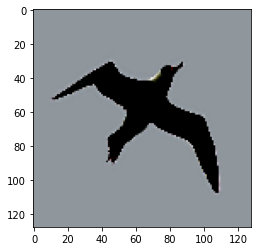

In [8]:
plt.imshow(imgs[-1])

# MODELOS

# StackGans

In [46]:
def conv3x3(out_planes, kernel_size = 3, strides = 1):
    "3x3 convolution with padding"
    return layers.Conv2D(out_planes, (kernel_size, kernel_size), strides=(strides, strides), padding='same', kernel_initializer='glorot_uniform')

def dense(units):
    return layers.Dense(units, use_bias=False)

def batch(momentum = 0.9):
    return layers.BatchNormalization(momentum=momentum)

def relu():
    return layers.Activation("relu")

def leaky_relu(alpha = 0.2):
    return layers.LeakyReLU(alpha=alpha)

def upBlock(out_planes):
    """
    Upsale the spatial size by a factor of 2
    """
    block =  tf.keras.Sequential([
        layers.UpSampling2D(size=(2, 2)),
        conv3x3(out_planes, 3, 1),
        #layers.Dropout(0.2),
        batch(),
        relu(),
    ])
    return block

def residual_block(x2):
    """
    Residual block in the generator network
    """
    tam_ini = 512

    x = conv3x3(tam_ini//2)(x2)
    x = batch()(x)
    x = relu()(x)
    
    x = conv3x3(tam_ini//2)(x)
    x = batch()(x)
    
    x = layers.add([x, x2])
    x = relu()(x)
    return x

In [47]:
def build_stage1_generator():
    """
    Builds a generator model used in Stage-I
    """
    tam_ini = 512

    input_layer = keras.Input(shape=(NOISE_SIZE,))

    x = dense(tam_ini*4*4)(input_layer)
    x = relu()(x)
    x = layers.Reshape((4, 4, tam_ini), input_shape=(tam_ini * 4 * 4,))(x)
    for i in range(1,5):
        x = upBlock(tam_ini//2**i)(x)
    x = conv3x3(3)(x)
    x = layers.Activation(activation='tanh')(x)
    stage1_gen = keras.Model(inputs=input_layer, outputs=x)
    return stage1_gen
    
def build_stage2_generator():
    """
    Create Stage-II generator containing the CA Augmentation Network,
    the image encoder and the generator network
    """
    tam_ini = 512
    
    input_lr_images = keras.Input(shape=(BASE_SIZE, BASE_SIZE, 3))

    # 2. Image Encoder
    #x = layers.ZeroPadding2D(padding=(1, 1))(input_lr_images)
    x = conv3x3(tam_ini//16)(input_lr_images)
    x = relu()(x)
    
    # x = layers.ZeroPadding2D(padding=(1, 1))(x)
    x = conv3x3(tam_ini//8, 4, 2)(x)
    x = batch()(x)
    x = relu()(x)
    
    #x = layers.ZeroPadding2D(padding=(1, 1))(x)
    x = conv3x3(tam_ini//4, 4, 2)(x)
    x = batch()(x)
    x = relu()(x)
    
    x = conv3x3(tam_ini//2, 4, 2)(x)
    x = batch()(x)
    x = relu()(x)
    
    # 4.layers. Residual blocks
    for _ in range(2): #2 para 128, 4 para 256 etc
        x = residual_block(x)
    
    # 5.layers. Upsampling blocks    
    for i in range(2,6):
        x = upBlock(tam_ini//(2**i))(x)
    
    x = conv3x3(3)(x)
    x = layers.Activation('tanh')(x)

    model = keras.Model(inputs=input_lr_images, outputs=x)
    return model

In [48]:
gen1 = build_stage1_generator()
gen1.summary()
gen2 = build_stage2_generator()
gen2.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128)]             0         
                                                                 
 dense_10 (Dense)            (None, 8192)              1048576   
                                                                 
 activation_37 (Activation)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 sequential_12 (Sequential)  (None, 8, 8, 256)         1180928   
                                                                 
 sequential_13 (Sequential)  (None, 16, 16, 128)       295552    
                                                                 
 sequential_14 (Sequential)  (None, 32, 32, 64)        740

                                                                                                  
 sequential_17 (Sequential)     (None, 32, 32, 64)   74048       ['sequential_16[0][0]']          
                                                                                                  
 sequential_18 (Sequential)     (None, 64, 64, 32)   18592       ['sequential_17[0][0]']          
                                                                                                  
 sequential_19 (Sequential)     (None, 128, 128, 16  4688        ['sequential_18[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_99 (Conv2D)             (None, 128, 128, 3)  435         ['sequential_19[0][0]']          
                                                                                                  
 activatio

In [49]:
def build_stage1_discriminator():
    """
    Create a model which takes two inputs
    1. One from above network
    2. One from the embedding layer
    3. Concatenate along the axis dimension and feed it to the last module which produces final logits
    """
    tam_ini = 32

    input_layer = keras.Input(shape=(BASE_SIZE, BASE_SIZE, 3))
    x = conv3x3(tam_ini, 4, 2)(input_layer)
    x = leaky_relu()(x)    

    for i in range(1,4):
        x = conv3x3(tam_ini*(2**i), 4, 2)(x)
        x = batch()(x)
        x = leaky_relu()(x)
        
    x = conv3x3(1,1,1)(x)
    x = layers.Flatten()(x)
    x = dense(1)(x)
    x = layers.Activation('sigmoid')(x)

    stage1_dis = keras.Model(input_layer, x)
    return stage1_dis

def build_stage2_discriminator():
    """
    Create Stage-II discriminator network
    """
    
    tam_ini = 32
    input_layer = keras.Input(shape=(BASE_SIZE*2, BASE_SIZE*2, 3))    

    x = conv3x3(tam_ini, 4, 2)(input_layer)
    x = leaky_relu()(x)
    
    for i in range(1,5):
        x = conv3x3(tam_ini*(2**i), 4, 2)(x)
        x = batch()(x)
        x = leaky_relu()(x) 
    
    
   # x = conv3x3(tam_ini*8, 1, 1)(x)
   # x = batch()(x)
   # x = leaky_relu()(x) 
   # 
   # x = conv3x3(tam_ini*4, 1, 1)(x)
   # x = batch()(x)
#
   # x2 = conv3x3(tam_ini*2, 3, 1)(x)
   # x2 = batch()(x2)
   # x2 = leaky_relu()(x2) 
   # 
   # x2 = conv3x3(tam_ini*4, 1, 1)(x)
   # x2 = batch()(x2)
   # 
   # added_x = layers.add([x, x2])
   # added_x = leaky_relu()(added_x)

    
    #x3 = conv3x3(tam_ini*8, 1, 1)(added_x)
    #x3 = batch()(x3)
    #x3 = leaky_relu()(x3) 
    
    # x3 = layers.Flatten()(x3)
    # x3 = dense(1)(x3)
    # x3 = layers.Activation('sigmoid')(x3)
    
    x = conv3x3(1,1,1)(x)
    x = layers.Flatten()(x)
    x = dense(1)(x)
    x3 = layers.Activation('sigmoid')(x)

    stage2_dis = keras.Model(input_layer, x3)
    return stage2_dis

In [50]:
disc1 = build_stage1_discriminator()
disc1.summary()
disc2 = build_stage2_discriminator()
disc2.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_100 (Conv2D)         (None, 32, 32, 32)        1568      
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_101 (Conv2D)         (None, 16, 16, 64)        32832     
                                                                 
 batch_normalization_80 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                          

In [51]:
# adaptive discriminator augmentation
max_translation = 0.125
max_rotation = 0.125
max_zoom = 0.25

augmenter1 = keras.Sequential(
            [
                layers.InputLayer(input_shape=(BASE_SIZE, BASE_SIZE, 3)),
                # blitting/x-flip:
                # blitting/integer translation:
                layers.experimental.preprocessing.RandomTranslation(
                    height_factor=max_translation,
                    width_factor=max_translation,
                    interpolation="nearest",
                ),
                # geometric/rotation:
                layers.experimental.preprocessing.RandomRotation(factor=max_rotation),
                # geometric/isotropic and anisotropic scaling:
                layers.experimental.preprocessing.RandomZoom(
                    height_factor=(-max_zoom, 0.0), width_factor=(-max_zoom, 0.0)
                ),
            ],
            name="adaptive_augmenter",)

augmenter2 = keras.Sequential(
            [
                layers.InputLayer(input_shape=(BASE_SIZE*2, BASE_SIZE*2, 3)),
                # blitting/x-flip:
                # blitting/integer translation:
                layers.experimental.preprocessing.RandomTranslation(
                    height_factor=max_translation,
                    width_factor=max_translation,
                    interpolation="nearest",
                ),
                # geometric/rotation:
                layers.experimental.preprocessing.RandomRotation(factor=max_rotation),
                # geometric/isotropic and anisotropic scaling:
                layers.experimental.preprocessing.RandomZoom(
                    height_factor=(-max_zoom, 0.0), width_factor=(-max_zoom, 0.0)
                ),
            ],
            name="adaptive_augmenter",)

augmenter1.summary()

Model: "adaptive_augmenter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_translation (RandomT  (None, 64, 64, 3)        0         
 ranslation)                                                     
                                                                 
 random_rotation (RandomRota  (None, 64, 64, 3)        0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 64, 64, 3)         0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [52]:
def train_step1(real_images):
    # Sample random points in the latent space
    # TRAIN FIRST GAN
    #real_images1 = [x[0] for x in real_images]
    #real_images2 = [x[1] for x in real_images]
    
    # LABELS DISC
    labels_fake = tf.zeros((batch_size, 1))
    labels_fake += 0.2 * tf.random.uniform(labels_fake.shape)
    labels_real = tf.ones((batch_size, 1))
    labels_real -= 0.2 * tf.random.uniform(labels_real.shape)
    # LABELS GEN
    misleading_labels = tf.ones((2*batch_size, 1))
    
    # AUMENTAMOS LAS IMÁGENES
    real_images = augmenter1(tf.convert_to_tensor(real_images))
    random_latent_vectors = tf.random.normal(shape=(batch_size, NOISE_SIZE))
    generated_images = augmenter1(gen1(random_latent_vectors)) 
    
    # TRAIN DISCRIMINATOR
    # Imágenes generadas
    loss_disc = 0
    with tf.GradientTape() as tape:
        predictions = disc1(generated_images)
        d_loss = loss_fn(labels_fake, predictions)
        loss_disc += d_loss
    grads = tape.gradient(d_loss, disc1.trainable_weights)
    d_optimizer.apply_gradients((grad, var) for (grad, var) in zip(grads, disc1.trainable_variables) if grad is not None)

    # Imágenes reales    
    with tf.GradientTape() as tape:
        predictions = disc1(real_images)
        d_loss = loss_fn(labels_real, predictions)
        loss_disc +=d_loss
    grads = tape.gradient(d_loss, disc1.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, disc1.trainable_weights))
    d_optimizer.apply_gradients((grad, var) for (grad, var) in zip(grads, disc1.trainable_variables) if grad is not None)
    loss_disc /= 2
    
    # TRAIN GENERATOR
    
    loss_gen = 0
    random_latent_vectors = tf.random.normal(shape=(2*batch_size, NOISE_SIZE))
    with tf.GradientTape() as tape:
        generated_images = augmenter1(gen1(random_latent_vectors))
        predictions = disc1(generated_images)
        g_loss = loss_fn(misleading_labels, predictions)
        #g_loss = generator_loss(predictions)
        loss_gen += g_loss 
    grads = tape.gradient(g_loss, gen1.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, gen1.trainable_weights))
    g_optimizer.apply_gradients((grad, var) for (grad, var) in zip(grads, gen1.trainable_variables) if grad is not None)
    
    return loss_disc, loss_gen

In [61]:
def train_step2(real_images):
    
    # LABELS DISC
    labels_fake = tf.zeros((batch_size, 1))
    labels_fake += 0.2 * tf.random.uniform(labels_fake.shape)
    labels_real = tf.ones((batch_size, 1))
    labels_real -= 0.2 * tf.random.uniform(labels_real.shape)
    # LABELS GEN
    misleading_labels = tf.ones((2*batch_size, 1))
    
    # AUMENTAMOS LAS IMÁGENES
    real_images = augmenter2(tf.convert_to_tensor(real_images))
    random_latent_vectors = tf.random.normal(shape=(batch_size, NOISE_SIZE))
    generated_images = augmenter1(gen1(random_latent_vectors)) 
    generated_images = augmenter2(gen2(generated_images)) 

    # TRAIN DISCRIMINATOR
    loss_disc = 0
    # Imágenes generadas
    with tf.GradientTape() as tape:
        predictions = disc2(generated_images)
        #predictions_real = disc1(real_images)
        d_loss = loss_fn(labels_fake, predictions)
        #gp = gradient_penalty(batch_size, real_images, generated_images)
        #d_loss = discriminator_loss(predictions_real, predictions_fake)+10*gp
        loss_disc +=d_loss
    grads = tape.gradient(d_loss, disc2.trainable_weights)
    d_optimizer.apply_gradients((grad, var) for (grad, var) in zip(grads, disc2.trainable_variables) if grad is not None)
    
    # Imágenes reales    
    with tf.GradientTape() as tape:
        predictions = disc2(real_images)
        d_loss = loss_fn(labels_real, predictions)
        loss_disc +=d_loss
    grads = tape.gradient(d_loss, disc2.trainable_weights)
    d_optimizer.apply_gradients((grad, var) for (grad, var) in zip(grads, disc2.trainable_variables) if grad is not None)
    loss_disc /= 2

    # TRAIN GENERATOR
    loss_gen = 0
    random_latent_vectors = tf.random.normal(shape=(batch_size, NOISE_SIZE))
    generated_images = augmenter1(gen1(random_latent_vectors)) 
    cov1 = tfp.stats.covariance(generated_images, sample_axis=[1,2])
    media_rgb1 = tf.reduce_mean(generated_images, axis=[1,2])

    with tf.GradientTape() as tape:
        generated_images = augmenter2(gen2(generated_images))
        predictions = disc2(generated_images)
        g_loss = loss_fn(misleading_labels, predictions)
        #g_loss = generator_loss(predictions)
        loss_gen += g_loss 
        
    media_rgb2 = tf.reduce_mean(generated_images, axis=[1,2])
    rgb_media_loss = 0
    for i in range(len(media_rgb1)):
        rgb_media_loss+=tf.sqrt(tf.reduce_sum(tf.square([media_rgb1[i],media_rgb2[i]])))
    rgb_media_loss /= len(media_rgb1)       
        
    cov2 = tfp.stats.covariance(generated_images, sample_axis=[1,2])
    covs_loss = 0
    for i in range(len(cov1)):
        covs_loss += tf.sqrt(tf.reduce_sum(tf.square([cov1[i],cov2[i]])))
    covs_loss /= len(cov1)
    
    loss_color = 50*(rgb_media_loss+ 5*covs_loss)
    g_loss += loss_color
    loss_gen += loss_color #Experimental results indicate that the color-consistency regularization is very importan
    grads = tape.gradient(g_loss, gen2.trainable_weights)
    g_optimizer.apply_gradients((grad, var) for (grad, var) in zip(grads, gen2.trainable_variables) if grad is not None)

    return loss_disc, loss_gen, loss_color

In [64]:
#Train first gan
epochs = 500
batch_size = 64
learning_rate = 2e-4
beta_1 = 0.5
#beta_2 = 0.999

if not os.path.exists("models"):
    os.mkdir("models")
disc1.save('models/disc1.h5')  
gen1.save('models/gen1.h5') 
augmenter1.save('models/augmenter1.h5') 

split = "train"
prepare_caption1 = PREPARE_CAPTIONS(data_dir, split)
#filenames, captions, ixtoword, wordtoix, n_words = prepare_caption.load_text_data(data_dir, split)
filenames1, captions1 = prepare_caption1.load_text_data(data_dir, split)

split = "test"
prepare_caption2 = PREPARE_CAPTIONS(data_dir, split)
#filenames, captions, ixtoword, wordtoix, n_words = prepare_caption.load_text_data(data_dir, split)
filenames2, captions2 = prepare_caption2.load_text_data(data_dir, split)

filenames = filenames1 + filenames2
captions = captions1 + captions2
BASE_SIZE = 64
prepare_image = PREPARE_IMAGE(data_dir, split, captions, filenames, BASE_SIZE)


dataset = tf.data.Dataset.range(len(filenames)) 
dataset = dataset.shuffle(buffer_size=len(filenames)) # comment this line if you don't want to shuffle data
dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
dataset = dataset.repeat(epochs)


#discriminator = Discriminador()
#generator = Generator()
#model_clip = TFCLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
#tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

d_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)# , beta_2=beta_2)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)# , beta_2=beta_2)
loss_fn = tf.keras.losses.BinaryCrossentropy()#from_logits=True)

epoca = 0
num_batch = 0
when_end_epoch =int(len(filenames1)/batch_size)
dh2 = display("EPOCA: 0",display_id=True)

disc_loss_tracker_batch1 = []
gen_loss_tracker_batch1 = []
disc_loss_tracker_epoch1 = []
gen_loss_tracker_epoch1 = []

for batch in tqdm(dataset):
    if epoca!=0 and epoca%100==0:
        learning_rate = learning_rate/2
        d_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)#, beta_2=beta_2)
        g_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)#, beta_2=beta_2)
        disc1.save('models/disc1.h5')  
        gen1.save('models/gen1.h5') 
        augmenter1.save('models/augmenter1.h5') 
    if num_batch!=0 and num_batch%when_end_epoch==0:
        #if epoca%2==0:
        random_latent_vectors = tf.random.normal(shape=(8, NOISE_SIZE), mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
        fake_images = gen1([random_latent_vectors])
        n_row = 2
        n_col = 4
        _, axs = plt.subplots(n_row, n_col, figsize=(20,10))
        axs = axs.flatten()
        for img, ax in zip(fake_images, axs):
            ax.imshow((img+1)/2)
            ax.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.suptitle("GEN1")
        plt.show()

        disc_loss_tracker_epoch1.append(np.mean([disc_loss_tracker_batch1]))
        gen_loss_tracker_epoch1.append(np.mean([gen_loss_tracker_batch1]))
           
        epoca+=1
        dh2.update("EPOCA:"+str(epoca))
        disc_loss_tracker_batch1 = []
        gen_loss_tracker_batch1 = []
        
    # Cargo el batch y lo preparo ordenandolo en funcion de mas o menos palabras en el cap
    # imgs_list, caps_list, cap_len_list, cls_id_list, key_list, wrong_caps_list, wrong_cap_len_list, wrong_cls_id_list = [], [], [], [], [], [], [], [] 
   
    imgs_list = []
    for ind in batch:
        imgs, caps, cls_id, key, wrong_caps, wrong_cls_id = prepare_image.__getitem__(ind)
        imgs_list.append(imgs)

    loss_disc1, loss_gen1 = train_step1(imgs_list)
    disc_loss_tracker_batch1.append(loss_disc1)
    gen_loss_tracker_batch1.append(loss_gen1) 
    
    if num_batch == 0:
        dh1 = display("Loss DISC1:", np.mean([disc_loss_tracker_batch1]), " Loss GEN1:", np.mean([gen_loss_tracker_batch1]), display_id=True)
    if num_batch%(when_end_epoch//10)==0:
        dh1.update("Loss DISC1:"+str(np.mean([disc_loss_tracker_batch1]))+ " Loss GEN1:"+ str(np.mean([gen_loss_tracker_batch1])))
    num_batch += 1

Load filenames from: ../birds/train/filenames.pickle (8855)
Load filenames from: ../birds/train/filenames.pickle (8855)
filepath ../birds/captions.pickle
Load from:  ../birds/captions.pickle
Load filenames from: ../birds/test/filenames.pickle (2933)
Load filenames from: ../birds/test/filenames.pickle (2933)
filepath ../birds/captions.pickle
Load from:  ../birds/captions.pickle
Total filenames:  11788 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg


'EPOCA: 0'

  0%|          | 0/92000 [00:00<?, ?it/s]

'Loss DISC1:0.6967893Loss GEN 1:0.7966633'

'Loss DISC1:0.6967893Loss GEN 1:0.7966633'

'Loss DISC1:0.6967893Loss GEN 1:0.7966633'

'Loss DISC1:0.6967893Loss GEN 1:0.7966633'

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(disc_loss_tracker_epoch1, label = "discriminador")
plt.plot(gen_loss_tracker_epoch1, label="generator")
plt.legend()
plt.title("Losses discriminador 1 y generador 1")
plt.show()

In [ ]:
random_latent_vectors = tf.random.normal(shape=(8, NOISE_SIZE), mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
fake_images = gen1([random_latent_vectors])
n_row = 2
n_col = 4
_, axs = plt.subplots(n_row, n_col, figsize=(20,10))
axs = axs.flatten()
for img, ax in zip(fake_images, axs):
    ax.imshow((img+1)/2)
    ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("GEN1")
plt.show()

In [ ]:
#Train second gan
epochs = 500
batch_size = 64
learning_rate = 2e-4
beta_1 = 0.5
#beta_2 = 0.999

if not os.path.exists("models"):
    os.mkdir("models")
disc2.save('models/disc2.h5')  
gen2.save('models/gen2.h5') 
augmenter2.save('models/augmenter2.h5') 

split = "train"
prepare_caption1 = PREPARE_CAPTIONS(data_dir, split)
#filenames, captions, ixtoword, wordtoix, n_words = prepare_caption.load_text_data(data_dir, split)
filenames1, captions1 = prepare_caption1.load_text_data(data_dir, split)

split = "test"
prepare_caption2 = PREPARE_CAPTIONS(data_dir, split)
#filenames, captions, ixtoword, wordtoix, n_words = prepare_caption.load_text_data(data_dir, split)
filenames2, captions2 = prepare_caption2.load_text_data(data_dir, split)

filenames = filenames1 + filenames2
captions = captions1 + captions2
BASE_SIZE = 128
prepare_image = PREPARE_IMAGE(data_dir, split, captions, filenames, BASE_SIZE)


dataset = tf.data.Dataset.range(len(filenames)) 
dataset = dataset.shuffle(buffer_size=len(filenames)) # comment this line if you don't want to shuffle data
dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
dataset = dataset.repeat(epochs)


#discriminator = Discriminador()
#generator = Generator()
#model_clip = TFCLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
#tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

d_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)# , beta_2=beta_2)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)# , beta_2=beta_2)
loss_fn = tf.keras.losses.BinaryCrossentropy()#from_logits=True)

epoca = 0
num_batch = 0
when_end_epoch =int(len(filenames)/batch_size)
dh2 = display("EPOCA:", epoca)

disc_loss_tracker_batch2 = []
gen_loss_tracker_batch2 = []
color_loss_tracker_batch2 = []

disc_loss_tracker_epoch2 = []
gen_loss_tracker_epoch2 = []
color_loss_tracker_epoch2 = []

for batch in tqdm(dataset):
    if epoca!=0 and epoca%100==0:
        learning_rate = learning_rate/2
        d_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
        g_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
        disc2.save('models/disc2.h5')  
        gen2.save('models/gen2.h5') 
        augmenter2.save('models/augmenter2.h5') 
    if num_batch!=0 and num_batch%when_end_epoch==0:
        # random_latent_vectors = tf.random.uniform(shape=(cuantas_imgs_vis, NOISE_SIZE), minval=-1, maxval=1)
        random_latent_vectors = tf.random.normal(shape=(8, NOISE_SIZE), mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
        fake_images = gen1([random_latent_vectors])
        n_row = 2
        n_col = 4
        _, axs = plt.subplots(n_row, n_col, figsize=(20,10))
        axs = axs.flatten()
        for img, ax in zip(fake_images, axs):
            ax.imshow((img+1)/2)
            ax.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.suptitle("GEN1")
        plt.show()
            
        fake_images = gen2(fake_images)
        n_row = 2
        n_col = 4
        _, axs = plt.subplots(n_row, n_col, figsize=(20,10))
        axs = axs.flatten()
        for img, ax in zip(fake_images, axs):
            ax.imshow((img+1)/2)
            ax.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.suptitle("GEN2")
        plt.show()    
            
        
        disc_loss_tracker_epoch2.append(np.mean([disc_loss_tracker_batch2]))
        gen_loss_tracker_epoch2.append(np.mean([gen_loss_tracker_batch2]))
        color_loss_tracker_epoch2.append(np.mean([color_loss_tracker_batch2]))
        
        epoca+=1
        dh2.update("EPOCA:", epoca)

        disc_loss_tracker_batch2 = []
        gen_loss_tracker_batch2 = []
        color_loss_tracker_batch2 = []
    # Cargo el batch y lo preparo ordenandolo en funcion de mas o menos palabras en el cap
    # imgs_list, caps_list, cap_len_list, cls_id_list, key_list, wrong_caps_list, wrong_cap_len_list, wrong_cls_id_list = [], [], [], [], [], [], [], [] 
    # imgs_list, caps_list, cls_id_list, key_list, wrong_caps_list, wrong_cls_id_list = [], [], [], [], [], []
    imgs_list = []
    for ind in batch:
        imgs, caps, cls_id, key, wrong_caps, wrong_cls_id = prepare_image.__getitem__(ind)
        imgs_list.append(imgs)
        #caps_list.append(caps)

    loss_disc2, loss_gen2, loss_color = train_step2(imgs_list)
    disc_loss_tracker_batch2.append(loss_disc2)
    gen_loss_tracker_batch2.append(loss_gen2)
    color_loss_tracker_batch2.append(loss_color)
    if num_batch == 0:
        dh1 = display("Loss DISC2:", np.mean([disc_loss_tracker_batch2]), "Loss GEN 2", np.mean([gen_loss_tracker_batch2]), "Loss COLOR", np.mean([color_loss_tracker_batch2]))

    if num_batch%(when_end_epoch//10)==0:
        dh1.update("Loss DISC2:", np.mean([disc_loss_tracker_batch2]), "Loss GEN 2", np.mean([gen_loss_tracker_batch2]), "Loss COLOR", np.mean([color_loss_tracker_batch2]))
        
    num_batch += 1

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(disc_loss_tracker_epoch2, label = "discriminador")
plt.plot(gen_loss_tracker_epoch2, label="generator")
plt.plot(color_loss_tracker_epoch2, label="generator")

plt.legend()
plt.title("Losses discriminador 2, generador 2 y color")
plt.show()

In [28]:
random_latent_vectors = tf.random.normal(shape=(8, NOISE_SIZE), mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
fake_images = gen1([random_latent_vectors])
n_row = 2
n_col = 4
_, axs = plt.subplots(n_row, n_col, figsize=(20,10))
axs = axs.flatten()
for img, ax in zip(fake_images, axs):
    ax.imshow((img+1)/2)
    ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("GEN1")
plt.show()

fake_images = gen2(fake_images)
n_row = 2
n_col = 4
_, axs = plt.subplots(n_row, n_col, figsize=(20,10))
axs = axs.flatten()
for img, ax in zip(fake_images, axs):
    ax.imshow((img+1)/2)
    ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("GEN2")
plt.show()    

2022-03-23 18:23:41.358355: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'gen1' is not defined